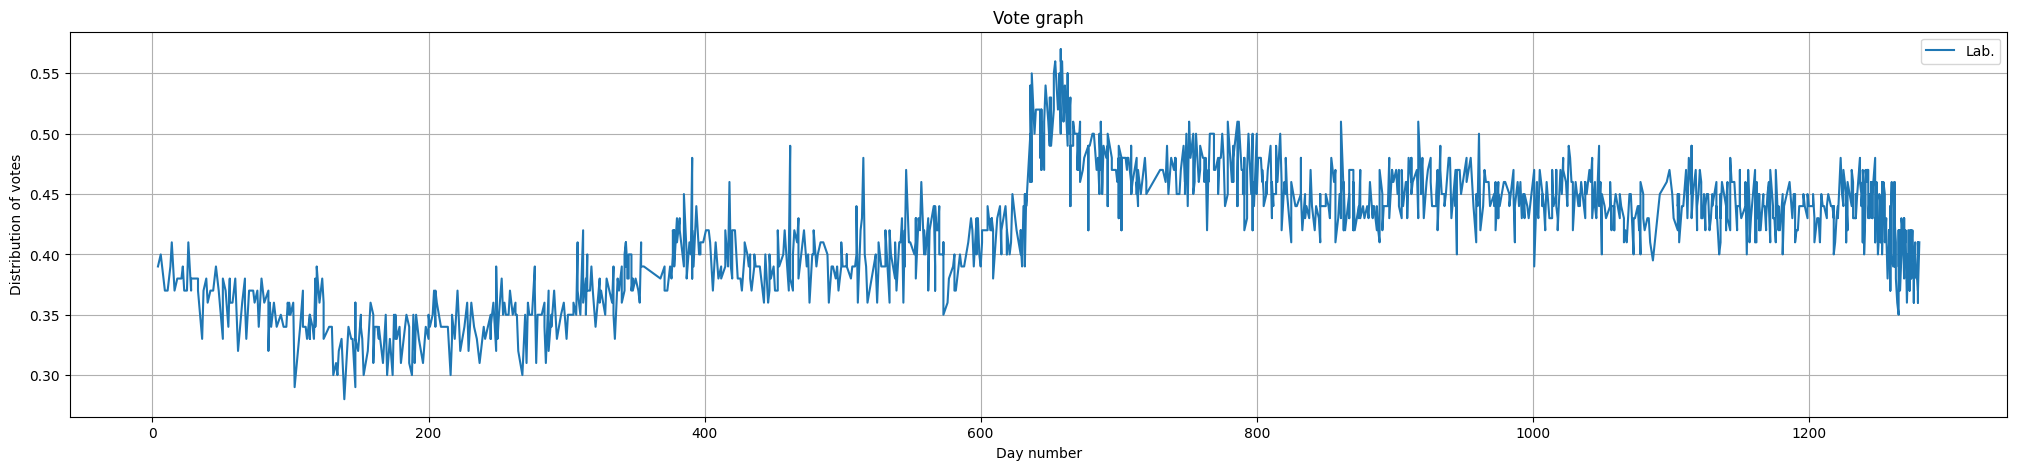

BaseLine Mean Squared Error (If-Else rule): 0.005856


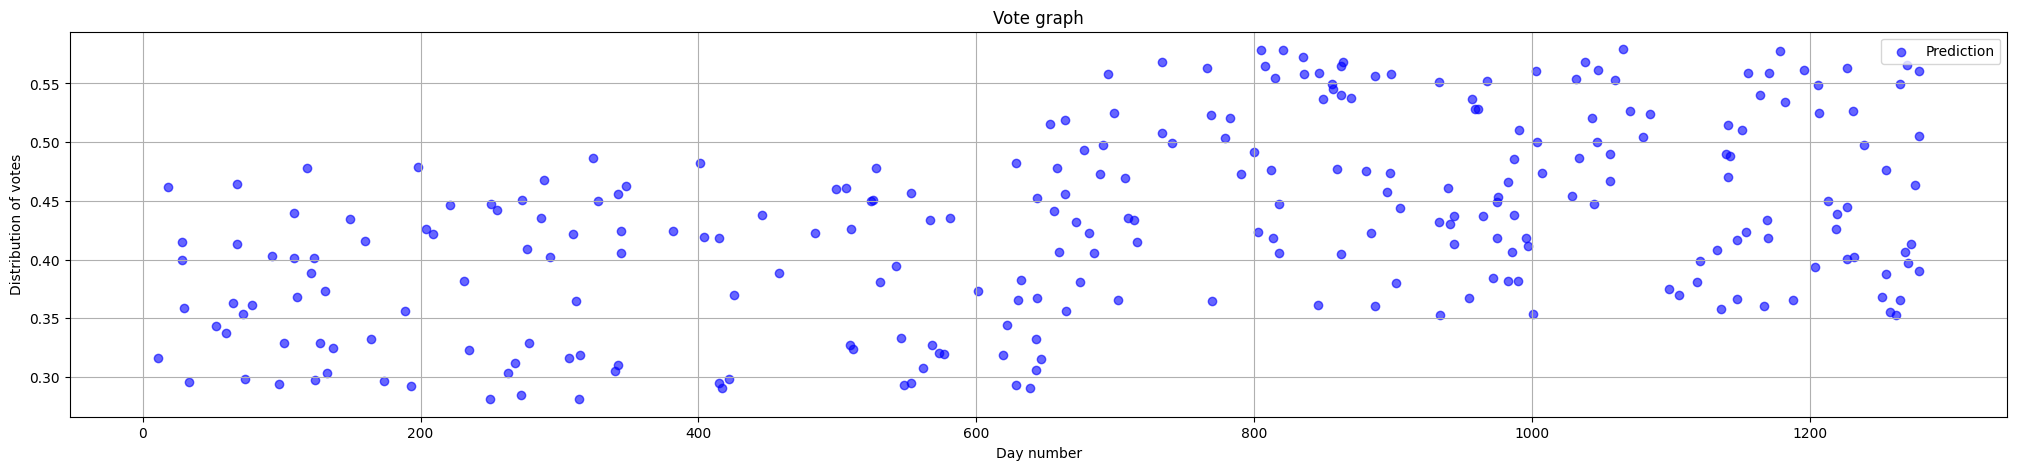

Test Mean Squared Error (Random Forest Without Best Parameters): 0.000397


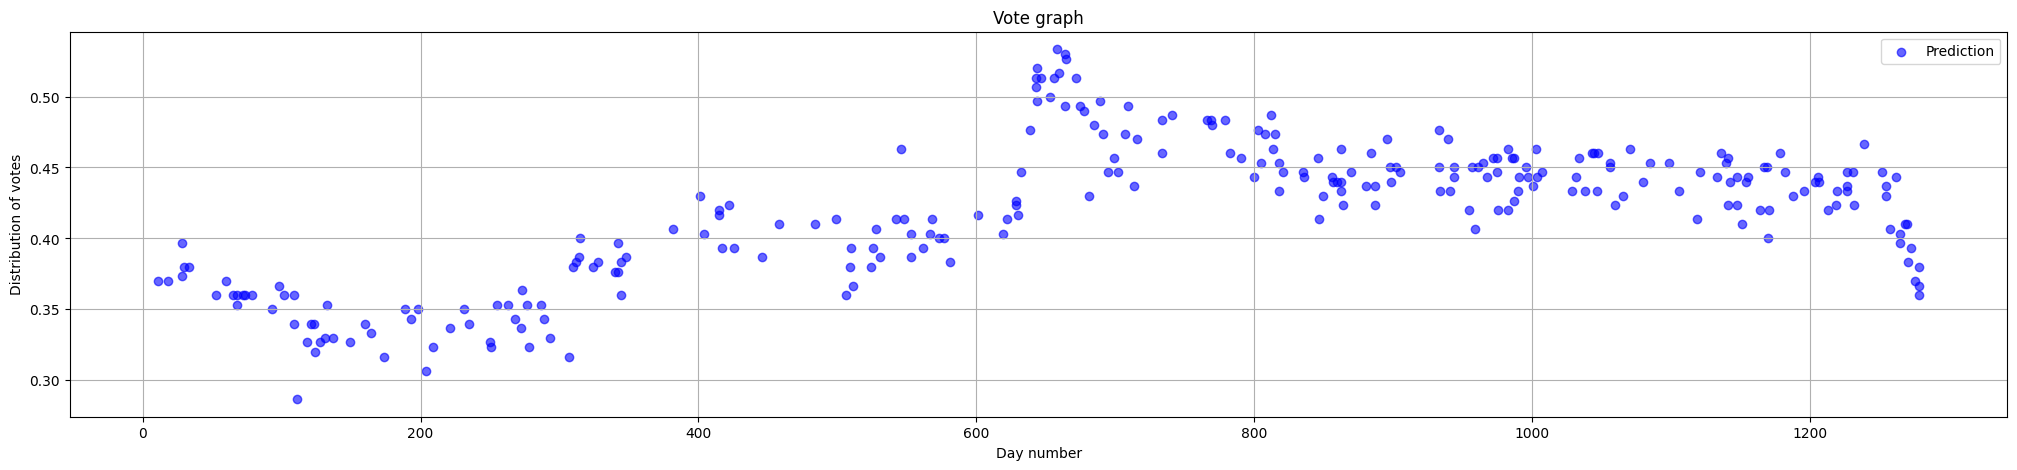

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
Test Mean Squared Error (Random Forest With Best Parameters): 0.000359


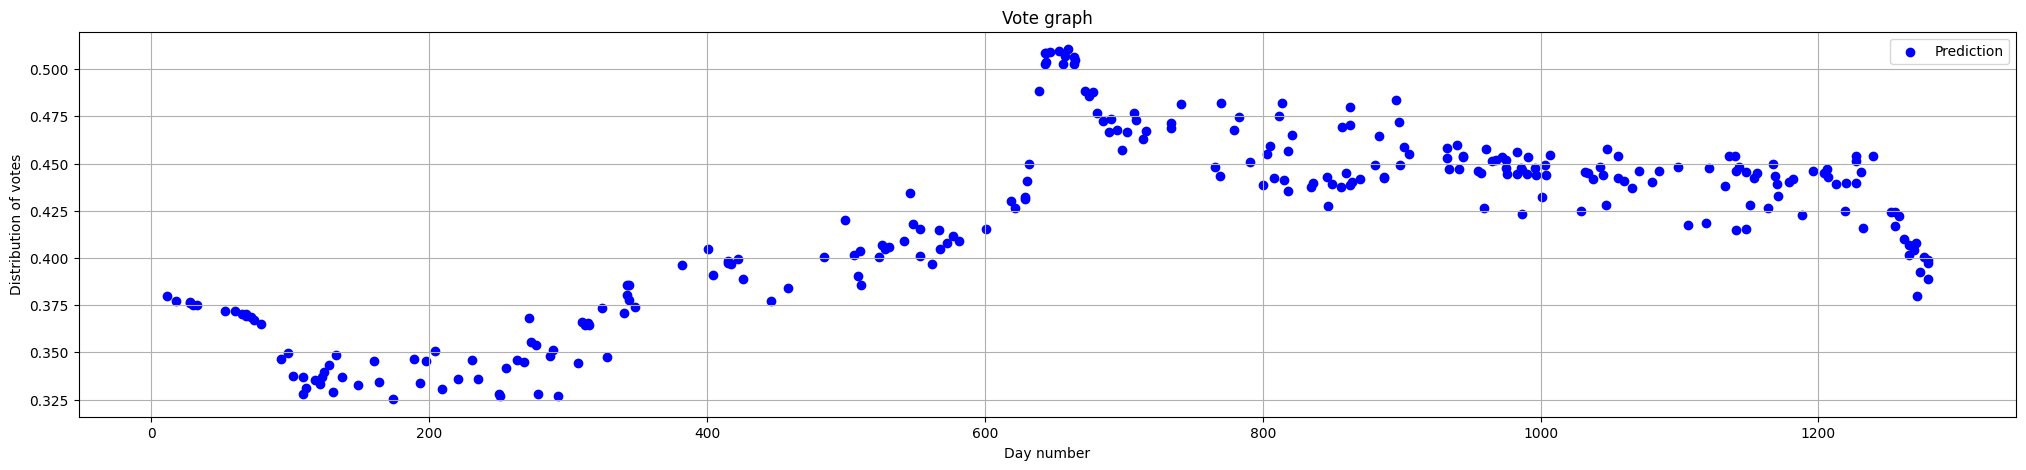

Test Mean Squared Error (My Random Forest Without Best Parameters): 0.000421


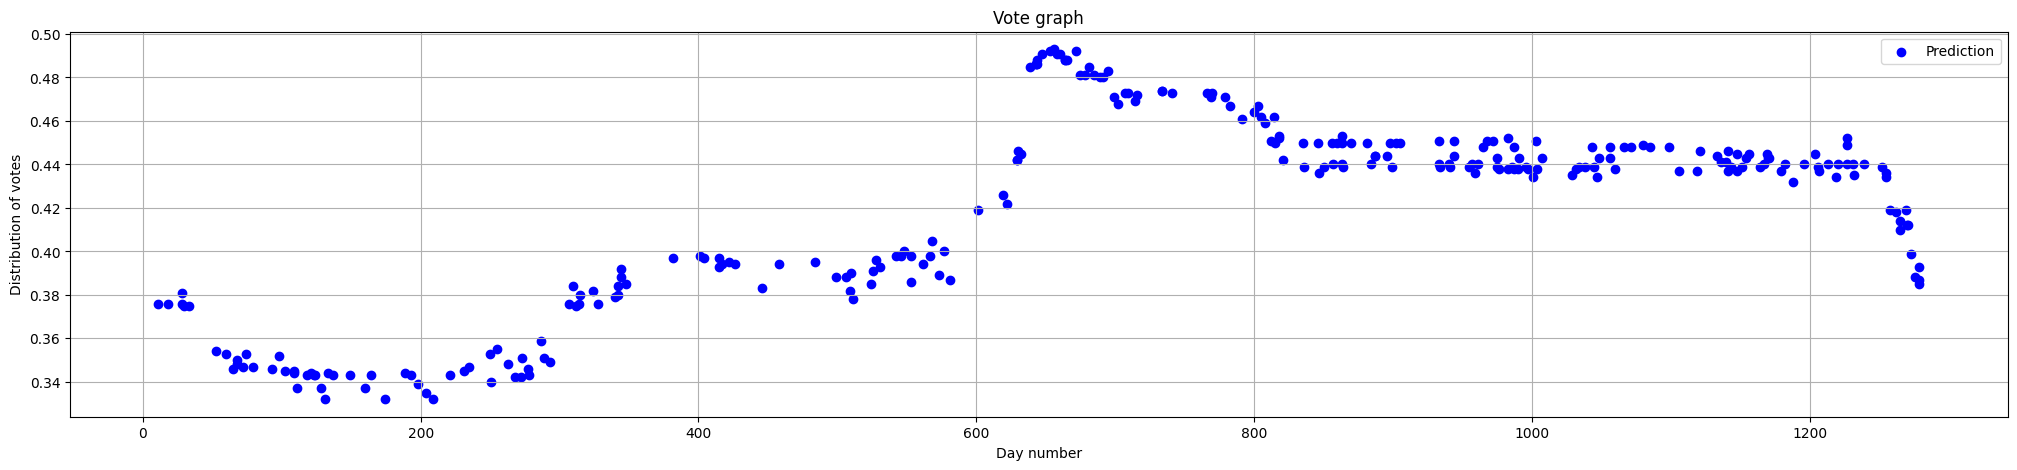

Test Mean Squared Error (My Random Forest With Best Parameters): 0.000351


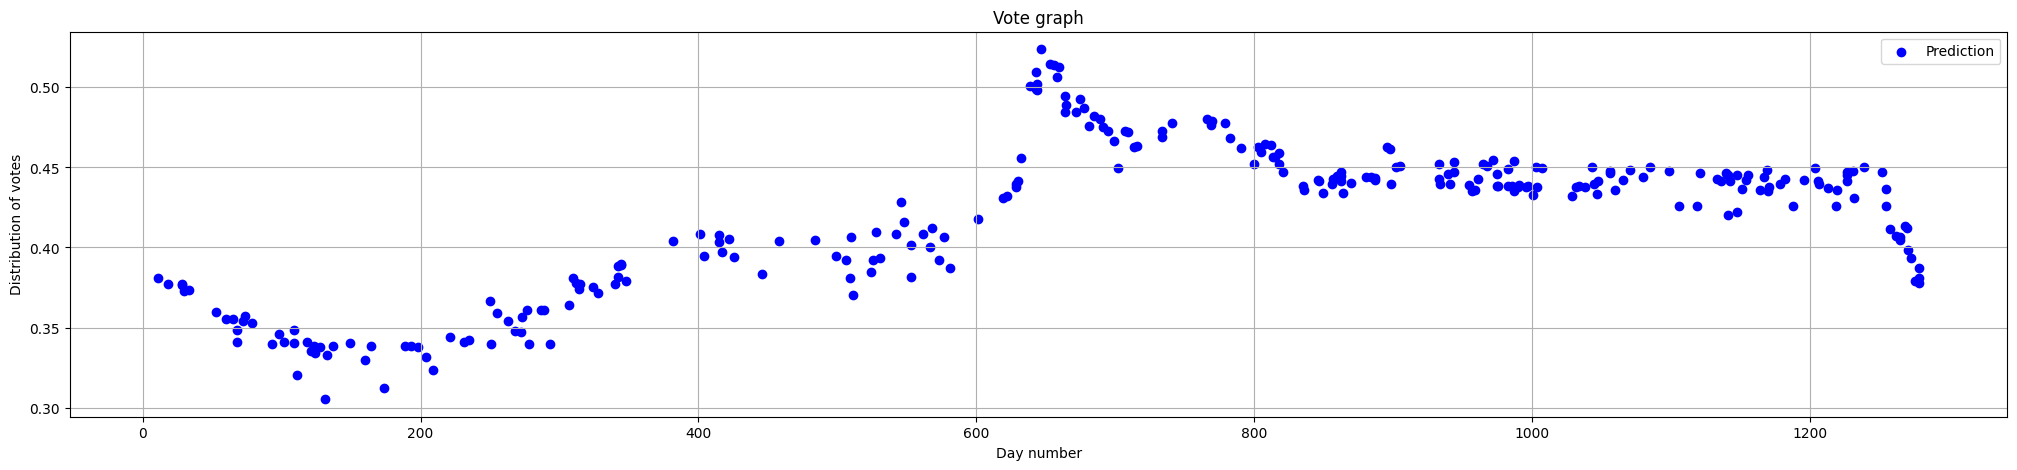

In [184]:
import re
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
pd.set_option('display.max_rows', None)

#BaseLine
def simple_baseline_rule(x):
    if x['Day number'] < 650:
        return np.random.uniform(0.28, 0.49)
    else:
        return np.random.uniform(0.35, 0.58)

#Convert days and months to day number. Period of day will return mid day of this period.
#First day is 2021 1 Jan
def Convert(y, d):
    ans = (int(y) - 2021) * 365  #In this case we haven't full leap years. In this case function will be more simple.
    if (d.find('–') == -1) :
        ans += int(d[:d.find(' ')]) + sum(DaysInYear[:Months.index(d[-3:])])
    elif (d.count(' ') == 1):
        a = int(d[:d.find('–')])
        b = int(d[d.find('–') + 1:d.find(' ')])
        ans += sum(DaysInYear[:Months.index(d[-3:])]) + (a + b) // 2
    else:
        fistMonth = Months.index(d[d.find(' ') + 1: d.find(' ') + 4])
        secondMonth = Months.index(d[-3:])
        a = sum(DaysInYear[:fistMonth]) + int(d[:d.find(' ')])
        b = sum(DaysInYear[:secondMonth]) + int(re.findall(r'\s(\d+)\s', d)[-1])  #Last number in str
        if (fistMonth > secondMonth):  #Case where period starts in one year and finishes in next year
            a -= 365
        ans += (a + b) // 2
        
    #Add extra Feb day in leap year
    if ((y == 2024) and (Months.index(d[-3:]) > 1)):
        ans += 1    
    return ans

#Constants for convert days and months to day number
Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
DaysInYear = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

#Open created cvs file from lab 1 for modification for comfortable graph view
df = pd.read_csv("fullDF.csv")
df = df.drop(df.columns[0], axis = 1)  #Remove extra id column

dayNumber = []
for year, days in zip(df[df.columns[0]], df[df.columns[1]]):
    dayNumber.append(Convert(year, days))

df = df.drop(df.columns[0], axis = 1)
df = df.drop(df.columns[0], axis = 1) #Remove old columns and insert converted days
df.insert(0, "Day number", dayNumber)

#Swap some rows in DataFrame for order
df = df.sort_values(by=df.columns[0])

#Delete some extra information
df[df.columns[1]] = df[df.columns[1]].str.replace(" \(MRP\)", "", regex=True)
df[df.columns[1]] = df[df.columns[1]].str.replace(r"\[permanent dead link\]", "", regex=True)
df['Client'] = df['Client'].fillna(df['Pollster'])

#Encoding category columns in DataFrame
#Area(Label Encoding)
df['Area_encoded'] = LabelEncoder().fit_transform(df['Area'])
df['Pollster_encoded'] = LabelEncoder().fit_transform(df['Pollster'])
df['Client_encoded'] = LabelEncoder().fit_transform(df['Client'])

df.plot(x="Day number", y='Lab.', kind='line', figsize=(25, 5))
plt.xlabel('Day number')
plt.ylabel('Distribution of votes')
plt.title('Vote graph')
plt.grid(True)
plt.show()

#Split DataFrame (train 60%, val 20%, test 20%)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=77)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=66)

#Remove extra rows.
X_train = train_df.drop(columns=['Pollster', 'Client', 'Area', 'Con.', 'Lab.', 'Lib. Dems', 'SNP', 'Green', 'Ref.', 'Others'])
X_val = val_df.drop(columns=['Pollster', 'Client', 'Area', 'Con.', 'Lab.', 'Lib. Dems', 'SNP', 'Green', 'Ref.', 'Others'])
X_test = test_df.drop(columns=['Pollster', 'Client', 'Area', 'Con.', 'Lab.', 'Lib. Dems', 'SNP', 'Green', 'Ref.', 'Others'])

#Choice targer
Y_train = train_df['Lab.']
Y_val = val_df['Lab.']
Y_test = test_df['Lab.']

#BaseLine If-Else rule
base_line_predication = X_test.apply(simple_baseline_rule, axis=1)
mse = mean_squared_error(Y_test, base_line_predication)
print(f'BaseLine Mean Squared Error (If-Else rule): {mse:.6f}')

plt.figure(figsize=(25, 5))
plt.scatter(X_test['Day number'], base_line_predication, alpha=0.6, color='b', label='Prediction')
plt.xlabel('Day number')
plt.ylabel('Distribution of votes')
plt.title('Vote graph')
plt.legend()
plt.grid(True)
plt.show()

#Create model using sklearn and use train data frame
model = RandomForestRegressor(n_estimators=3, random_state=77)
model.fit(X_train, Y_train)

#Check result by test data frame
test_predication = model.predict(X_test)
mse = mean_squared_error(Y_test, test_predication)
print(f'Test Mean Squared Error (Random Forest Without Best Parameters): {mse:.6f}')

plt.figure(figsize=(25, 5))
plt.scatter(X_test['Day number'], test_predication, alpha=0.6, color='b', label='Prediction')
plt.xlabel('Day number')
plt.ylabel('Distribution of votes')
plt.title('Vote graph')
plt.legend()
plt.grid(True)
plt.show()

#Create parameter options
params = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15]
}

#Find best parameter option
newModel = RandomForestRegressor(random_state=77)
grid_search = GridSearchCV(newModel, params, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_val, Y_val)
best_params = grid_search.best_params_
bestModel = grid_search.best_estimator_
print(f'Best Parameters: {best_params}')

#Test best model on test part
best_test_predication = bestModel.predict(X_test)
mse = mean_squared_error(Y_test, best_test_predication)
print(f'Test Mean Squared Error (Random Forest With Best Parameters): {mse:.6f}')

plt.figure(figsize=(25, 5))
plt.scatter(X_test['Day number'], best_test_predication, color='b', label='Prediction')
plt.xlabel('Day number')
plt.ylabel('Distribution of votes')
plt.title('Vote graph')
plt.legend()
plt.grid(True)
plt.show()

#My Random Forest
#Random Forest class
class RandomForest:
    #Base params
    def __init__(self, n_estimators, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    #Train model
    def fit(self, X, Y):
        #Reindex DataFrames 
        X = pd.DataFrame(X).reset_index(drop=True).astype(int).values
        Y = pd.Series(Y).reset_index(drop=True).astype(float).values
        np.random.seed(66)
        for _ in range(self.n_estimators):
            bootstrap = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            X_bootstrap = X[bootstrap]
            Y_bootstrap = Y[bootstrap]
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_bootstrap, Y_bootstrap)
            self.trees.append(tree)

    #Predictiom from model
    def predict(self, X):
        treePrediction = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(treePrediction, axis=0)

#DecisionTree class
class DecisionTree:
    #Base params
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    #Train Tree
    def fit(self, X, Y, depth=0):
        if (len(set(Y)) == 1 or ((self.max_depth is not None) and (depth >= self.max_depth))): #Check if set full same or depth is enough
            self.tree = Counter(Y).most_common(1)[0][0] #Choise final answer on current sheet
        else:
            best_split = self.best_split(X, Y)
            if best_split is None: #If best split is none choice final answer on current sheet
                 self.tree = Counter(y).most_common(1)[0][0]
            else:
                #Create 2 new nodes from base node
                feature, threshold = best_split
                left = X[:, feature] <= threshold
                right = X[:, feature] > threshold
                self.tree = {
                    'feature' : feature,
                    'threshold' : threshold,
                    'left' : DecisionTree(self.max_depth),
                    'right' : DecisionTree(self.max_depth)
                }
                self.tree['left'].fit(X[left], Y[left], depth + 1)
                self.tree['right'].fit(X[right], Y[right], depth + 1)

    #Find best split
    def best_split(self, X, Y):
        best_split = None
        best_impurity = float('inf')
        n_samples, n_features = X.shape
        for feature in range(n_features): #Search all features
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds: #Search all thresholds
                left = X[:, feature] <= threshold
                right = X[:, feature] > threshold
                if (len(Y[left]) == 0 or len(Y[right]) == 0): #Skip empty splits
                    continue
                #Find best impurity for best split
                impurity = self.weighted_impurity(Y[left], Y[right])
                if impurity < best_impurity:
                    best_impurity = impurity
                    best_split = (feature, threshold)
        return best_split

    #Count impurity for some split
    def weighted_impurity(self, left, right):
        total = len(left) + len(right)
        return len(left) / total * self.gini(left) + len(right) / total * self.gini(right)

    #Count gini index
    def gini(self, y):
        counts = Counter(y)
        return 1.0 - sum((count / len(y)) ** 2 for count in counts.values())

    def predict(self, X):
        X = pd.DataFrame(X).reset_index(drop=True).astype(int).values
        return np.array([self.single_predict(x) for x in X])

    def single_predict(self, X):
        if not isinstance(self.tree, dict):
            return self.tree #Return answer if node is sheet
        if float(X[self.tree['feature']]) <= self.tree['threshold']:
            return self.tree['left'].single_predict(X)
        else:
            return self.tree['right'].single_predict(X)

my_model = RandomForest(n_estimators=10, max_depth=5)
my_model.fit(X_train, Y_train)
my_test_predication = my_model.predict(X_test)
mse = mean_squared_error(Y_test, my_test_predication)

print(f'Test Mean Squared Error (My Random Forest Without Best Parameters): {mse:.6f}')
plt.figure(figsize=(25, 5))
plt.scatter(X_test['Day number'], my_test_predication, color='b', label='Prediction')
plt.xlabel('Day number')
plt.ylabel('Distribution of votes')
plt.title('Vote graph')
plt.legend()
plt.grid(True)
plt.show()

my_best_model = RandomForest(n_estimators=150, max_depth=10)
my_best_model.fit(X_train, Y_train)
my_best_test_predication = my_best_model.predict(X_test)
mse = mean_squared_error(Y_test, my_best_test_predication)

print(f'Test Mean Squared Error (My Random Forest With Best Parameters): {mse:.6f}')
plt.figure(figsize=(25, 5))
plt.scatter(X_test['Day number'], my_best_test_predication, color='b', label='Prediction')
plt.xlabel('Day number')
plt.ylabel('Distribution of votes')
plt.title('Vote graph')
plt.legend()
plt.grid(True)
plt.show()